In [1]:
!pwd

/Users/alexkim/Documents/GitHub/지웅_DACON_AI_competition_for_predicting_Lymph_node_metastasis_of_breast_cancer/code


# Data Download

구글 드라이브에서 파일 다운로드 (explained by chat_gpt)
> 해당 코드는 Linux나 Unix 기반 운영체제에서 사용할 수 있는 wget 명령어를 사용하여 구글 드라이브에서 파일을 다운로드하는 코드입니다. 이때 wget 명령어는 인터넷 상의 파일을 다운로드하기 위해 사용되는 명령어로, 다양한 옵션들을 제공합니다.

> 구체적으로, 이 코드에서는 --load-cookies 옵션을 사용하여 cookies.txt 파일에서 쿠키 정보를 로드합니다. 쿠키는 웹 사이트에 접속할 때 브라우저에서 생성되는 정보로, 해당 사이트에 대한 로그인 정보나 세션 정보 등을 저장합니다. 이때 쿠키는 인증된 사용자만 해당 사이트에 접근할 수 있도록 보안을 유지하기 위해 사용됩니다.

> 이후, wget 명령어를 사용하여 https://docs.google.com/uc?export=download 링크로 요청을 보내고, 응답받은 쿠키 정보와 함께 파일 다운로드 링크를 생성합니다. 이때 다운로드 링크는 구글 드라이브의 공유 링크와는 다른 형식으로 생성되므로, 이를 위한 추가적인 처리가 필요합니다.

>마지막으로 생성한 다운로드 링크를 다시 wget 명령어로 요청하면, 파일을 다운로드할 수 있습니다. 이때 -O 옵션을 사용하여 다운로드 받을 파일의 이름을 FILENAME 변수로 지정한 값인 open.zip으로 설정합니다. 또한, rm 명령어를 사용하여 다운로드에 사용된 쿠키 정보가 저장된 cookies.txt 파일을 삭제합니다.

In [7]:
FILEID = "1q4d8FmF452uJ9SdlW1zQ2SMJYAphKwts"
FILENAME = 'open.zip'
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf ~/cookies.txt

In [2]:
# 필요한 폴더들 생성
import os
folders = ['result','./result/inference','dataset','./dataset/clinical_data','./dataset/json']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Unzip File

In [6]:
import zipfile
def unzip_file(zip_file_path, extract_folder_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        zip_file.extractall(extract_folder_path)
        
zip_file_path = './open.zip'
extract_folder_path = './dataset'

# unzip_file(zip_file_path, extract_folder_path)

# Move Files from open.zip

In [52]:
import os
os.listdir('./dataset')

['clinical_data',
 '.DS_Store',
 'train_imgs',
 'json',
 'test_imgs',
 'train_masks',
 'sample_submission.csv']

In [51]:
# 임상 항목 폴더로 해당 파일 이동
import shutil
move_file = ['./dataset/clinical_info.xlsx','./dataset/test.csv','./dataset/train.csv']
for file in move_file:
    if os.path.exists(file):
        shutil.move(file, './dataset/clinical_data')

> 올바른 파일 경로
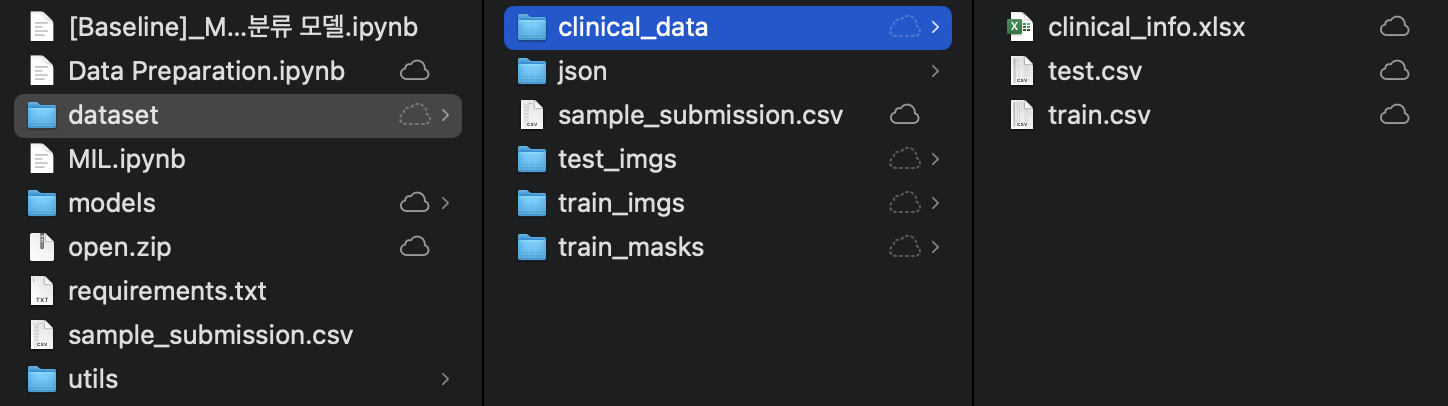

# import

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime
from tqdm.auto import tqdm
pd.set_option('display.max.colwidth', 150)
pd.set_option('display.max.row', 500)

import warnings
warnings.filterwarnings('ignore')

# Image_Data 확인

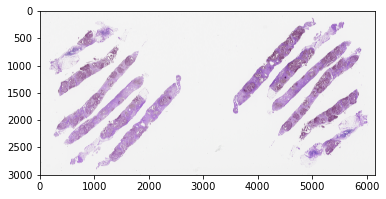

In [12]:
trian_img = './dataset/train_imgs/BC_01_0001.png'
img = cv2.imread(trian_img, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()

# 이미지 전처리
- 픽셀 밀도 : GRAYSCALE 값이 240 이하인 픽셀의 비율
- 픽셀 밀도 80% 미만 이미지 삭제 (# 0.7 default)

## 이미지 전처리 사용자 함수

In [54]:
def preprocessing_images(input_dir, crop_size, min_img_density, flag):
    input_img_name_list = sorted(os.listdir(input_dir))
    print(f"The number of images : {len(input_img_name_list)}")
    print("Images Preprocessing...")
    output_dir = input_dir + "_cropped"

    # output_dir 폴더 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_name in tqdm(input_img_name_list):
        img = os.path.join(input_dir, img_name)
        cv2_img = cv2.imread(img, flag)
        for row, start_y_pixel in enumerate(range(0, cv2_img.shape[0], crop_size)):
            for col, start_x_pixel in enumerate(range(0, cv2_img.shape[1], crop_size)):
                # 이미지 자르기
                croped_img = cv2_img[start_y_pixel: start_y_pixel +
                                     crop_size, start_x_pixel: start_x_pixel + crop_size]

                # 밀도 계산
                height, width = croped_img.shape[:2]
                img = cv2.cvtColor(croped_img, cv2.COLOR_BGR2GRAY)
                if len(img[img < 240]) / (height*width) >= min_img_density:
                    # 이미지 패딩
                    if height != width:
                        top = bottom = left = right = 0
                        if (height != crop_size) | (width != crop_size):
                            bottom = crop_size - height
                            right = crop_size - width

                        borderType = cv2.BORDER_CONSTANT
                        value = 244  # 패딩을 채울 색상
                        croped_img = cv2.copyMakeBorder(
                            croped_img, top, bottom, left, right, borderType, None, value)
                    # 이미지 저장
                    cv2.imwrite(
                        f'{output_dir}/{img_name.split(".")[0]}_({row+1:03d},{col+1:03d}).png', croped_img)

    sample_img = random.choice(os.listdir(output_dir))
    img = os.path.join(output_dir, sample_img)
    cv2_img = cv2.imread(img)
    print(f"Sample Image : {sample_img}")
    plt.imshow(cv2_img)
    plt.show()

    print(f"The number of cropped images : {len(os.listdir(output_dir))}")
    display("완료")

### train images preprocessing

  0%|          | 0/2 [00:00<?, ?it/s]

The number of images : 1000
Images Preprocessing...


  0%|          | 0/1000 [00:00<?, ?it/s]

Sample Image : BC_01_2998_(008,031).png


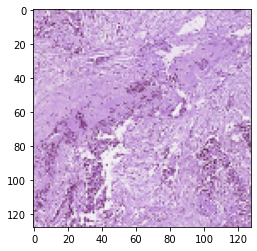

The number of cropped images : 95022


'완료'

The number of images : 250
Images Preprocessing...


  0%|          | 0/250 [00:00<?, ?it/s]

Sample Image : BC_01_3205_(012,035).png


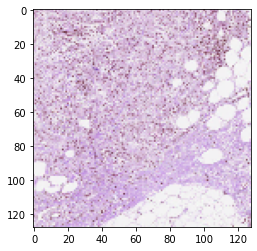

The number of cropped images : 23990


'완료'

In [55]:
# 크롭하려는 img 폴더
input_dir_list = ['./dataset/train_imgs', './dataset/test_imgs']

# 크롭할 사이즈
crop_size = 128

# 최소 픽셀 밀도
min_img_density = 0.8 # 0.7 default

# 이미지 불러오는 형식
flag = cv2.IMREAD_UNCHANGED

# image cropping
for input_dir in tqdm(input_dir_list):
    preprocessing_images(input_dir, crop_size, min_img_density, flag)